<a href="https://colab.research.google.com/github/younesabdolmalaky/home-price/blob/main/Home_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 66.9MB/s]


In [ ]:
! unzip /content/house-prices-advanced-regression-techniques.zip

Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder , MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


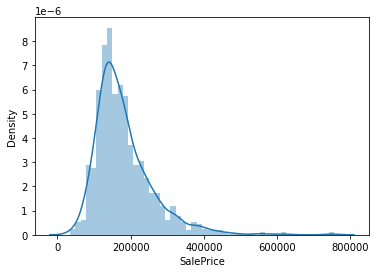

In [ ]:
import seaborn as sns
import numpy as np
sns.distplot(df['SalePrice'] , bins =50);


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


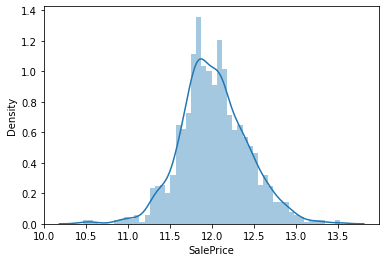

In [ ]:
sns.distplot(np.log(df['SalePrice']+1) , bins =50);

In [ ]:
(df.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [ ]:
df = df.drop(['Id','MiscFeature' , 'Fence' , 'PoolQC' ,'Alley' , 'FireplaceQu'],axis = 'columns')

In [ ]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(exclude=['float64' , 'int64']).columns

In [ ]:
df = df.dropna(subset = categorical_cols)

In [ ]:
df = pd.get_dummies(df)

In [ ]:
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df['Price'] = df['SalePrice']
df = df.drop("SalePrice", axis='columns')

In [ ]:
df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Price
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,223500.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,140000.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,175000.0
1334,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,210000.0
1335,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,266500.0
1336,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,142125.0


In [ ]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

In [ ]:
y = data[: ,df.columns.get_loc("Price") ]
X = np.delete(data, df.columns.get_loc("Price") , axis=1)
y=y.astype('float')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install cupy-cuda92 && \
!pip install pynvrtc && \
!/tmp/clean-layer.sh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 MB 13.5 MB/s eta 0:00:00
/bin/bash: !pip: command not found


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(eval_metric='R2',iterations=20000) 
model.fit(X_train , y_train , eval_set = (X_test , y_test))

Streaming output truncated to the last 5000 lines.
15005:	learn: 0.9998850	test: 0.8819155	best: 0.8826621 (5887)	total: 1m 15s	remaining: 25s
15006:	learn: 0.9998851	test: 0.8819159	best: 0.8826621 (5887)	total: 1m 15s	remaining: 25s
15007:	learn: 0.9998851	test: 0.8819150	best: 0.8826621 (5887)	total: 1m 15s	remaining: 25s
15008:	learn: 0.9998851	test: 0.8819152	best: 0.8826621 (5887)	total: 1m 15s	remaining: 25s
15009:	learn: 0.9998852	test: 0.8819149	best: 0.8826621 (5887)	total: 1m 15s	remaining: 25s
15010:	learn: 0.9998852	test: 0.8819150	best: 0.8826621 (5887)	total: 1m 15s	remaining: 25s
15011:	learn: 0.9998852	test: 0.8819150	best: 0.8826621 (5887)	total: 1m 15s	remaining: 25s
15012:	learn: 0.9998853	test: 0.8819148	best: 0.8826621 (5887)	total: 1m 15s	remaining: 25s
15013:	learn: 0.9998853	test: 0.8819151	best: 0.8826621 (5887)	total: 1m 15s	remaining: 25s
15014:	learn: 0.9998854	test: 0.8819143	best: 0.8826621 (5887)	total: 1m 15s	remaining: 25s
15015:	learn: 0.9998855	test:

In [ ]:
r2_score(y_pred , y_test)

NameError: ignored

In [ ]:
data_test_true = pd.DataFrame(X_test)
data_test_pred = pd.DataFrame(X_test)

In [ ]:
data_test_true['Price'] = y_test
data_test_pred['Price'] = y_pred

In [ ]:
inverserd_data_true = scaler.inverse_transform(data_test_true)
inverserd_data_pred = scaler.inverse_transform(data_test_pred)

In [ ]:
pd.Dataframe(inverserd_data_true)

In [ ]:
y_test = inverserd_data_true[:,265]
y_pred = inverserd_data_pred[:,265]

In [ ]:
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

In [ ]:
r2_score(y_test ,y_pred)

In [ ]:
#importing the necessary libraries 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix 
  
#loading the dataset 
data = pd.read_csv('dataset.csv') 
  
#separating the independent and dependent variables 
X = data.iloc[:, :-1].values  #independent variables 
y = data.iloc[:, -1].values   #dependent variable (target)  
  
#handling missing values with mean imputation  
from sklearn.impute import SimpleImputer    #for missing values in numerical columns  
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')    #creating an object of SimpleImputer class    #fitting the imputer object to our dataset  
imputer = imputer.fit(X[:, :])     #replacing missing values with mean of respective column    X[:, :] = imputer.transform(X[:, :])     #handling categorical data with label encoding    le = LabelEncoder()     #converting all categorical columns into numerical columns    X[:, 4] = le.fit_transform(X[:, 4])      #one hot encoding for multi-categorical columns    ohe = OneHotEncoder(categorical_features=[4])     X = ohe.fit_transform(X).toarray()      #splitting the dataset into training and testing sets    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)      #building a random forest classifier model    model = RandomForestClassifier()     model.fit(X_train, y_train)      #predicting on test set and calculating accuracy score    ypreds = model.predict(X_test)     print("Accuracy Score:", accuracy_score(ytest, ypreds))



In [ ]:
import pandas as pd 
import numpy as np 

#read in the dataset 
df = pd.read_csv('my_dataset.csv') 

#create new features by combining existing columns 
df['new_feature1'] = df['col1'] + df['col2'] 
df['new_feature2'] = df['col3'] * df['col4'] 
df['new_feature3'] = np.sqrt(df['col5']) 
df['new_feature4'] = np.log(df['col6']) 

#save the new dataset with the new features included 
df.to_csv('my_dataset_with_features.csv', index=False)